### This notebook generates the moisture-precip relationships for MCSs in the reanalysis-convective tracking data. First import libraries and constants.

In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from matplotlib import cm
from numpy import unravel_index

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [2]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air

## Loading ERA-I data

In [3]:
#How many precipitating versus non-precipitating MCSs? Roughly 40-50% each year.
#for i in np.arange( 1983, 2009 ):
#    o1 = xr.open_dataset('/groups/sylvia/JAS-MCS-rain/ERAI/colloc_' + str(i) + '.nc')['occurrence']
#    o2 = xr.open_dataset('/groups/sylvia/JAS-MCS-rain/ERAI/colloc_' + str(i) + '_NZ.nc')['occurrence']
#    print( len(o1), len(o2), len(o1)-len(o2), (len(o1)-len(o2))/len(o1)*100 )
#    print( '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~' )

#/xdisk/sylvia/MCS_clim/ausgabe/meteo_clim/nc/ERAI/colloc_1983_NZ.nc
display( xr.open_dataset('/groups/sylvia/JAS-MCS-rain/ERAI/colloc_1983_NZ.nc') )

<xarray.Dataset>
Dimensions:                     (altitude: 32, occurrence: 18082)
Dimensions without coordinates: altitude, occurrence
Data variables: (12/47)
    z                           (altitude) float32 ...
    pressure                    (altitude) float32 ...
    year                        (occurrence) int64 ...
    month                       (occurrence) int64 ...
    day                         (occurrence) int64 ...
    hour                        (occurrence) int64 ...
    ...                          ...
    tpre6                       (occurrence, altitude) float32 ...
    tpre9                       (occurrence, altitude) float32 ...
    surface latent heat flux    (occurrence) float32 ...
    surface sensible heat flux  (occurrence) float32 ...
    pmax                        (occurrence) float32 ...
    pacc                        (occurrence) float32 ...
Attributes:
    history:  Sat Dec 30 10:30:52 2023: ncrename -v w,omega colloc_1983_NZ.nc...
    NCO:      netCDF Operators version 5.0.4-alpha01 (Homepage = http://nco.s...

In [4]:
# array of years
years = np.arange( 1983, 2008 )

# create list of file names
file_years = file_concatenator(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
print(np.nanmin(minlat_array))
maxlat_array = nc_open_compile(file_years,"max latitude")
print(np.nanmax(maxlat_array))
tropical_indx = np.argwhere( (minlat_array >= -30) & (maxlat_array <= 30) )[:,0]
print(tropical_indx.shape)

# applying same for MCS lifetime and morphology
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERAI = negative_to_nan(lifetime_array)[tropical_indx]
maxrad_array = nc_open_compile(file_years,"maxrad")
maxrad_ERAI = negative_to_nan(maxrad_array)[tropical_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERAI = negative_to_nan(minctt_array)[tropical_indx]

-56.0
56.0
(695667,)


In [5]:
# array of years
years = np.arange( 1983, 2008 )

# create list of file names
file_years = file_concatenator(years)

# creating cape array from different files and treating for negatives
cape_array = nc_open_compile(file_years,"cape")
cape_ERAI = negative_to_nan(cape_array)[tropical_indx]
capepre_array = nc_open_compile(file_years,"capepre")
capepre_ERAI = negative_to_nan(capepre_array)[tropical_indx]
capepre6_array = nc_open_compile(file_years,"capepre6")
capepre6_ERAI = negative_to_nan(capepre6_array)[tropical_indx]

# applying same for pmax and pacc
pmax_array = nc_open_compile(file_years,"pmax")
pmax_ERAI = negative_to_nan(pmax_array)[tropical_indx]
pacc_array = nc_open_compile(file_years,"pacc")
pacc_ERAI = negative_to_nan(pacc_array)[tropical_indx]*3600 # convert to m3 / h

# extract pressure from the data files
# water vapour levels opened and vstacked, negatives removed
qv_array = nc_open_compile( file_years, "qv", 'stack' )
qv_ERAI = negative_to_nan(qv_array)[tropical_indx]
qvpre_array = nc_open_compile( file_years, "qvpre", 'stack' )
qvpre_ERAI = negative_to_nan(qvpre_array)[tropical_indx]
qvpre6_array = nc_open_compile( file_years, "qvpre6", 'stack' )
qvpre6_ERAI = negative_to_nan(qvpre6_array)[tropical_indx]

#pressure level values converted into double point precision
#factor of 100 converts hPa to Pa. we want to use SI units exclusively below.
plev_ERAI = np.double((xr.open_dataset(file_years[0])).pressure.data)*100

In [6]:
# calculate the saturation vapor mixing ratio, Curry & Webster (4.37)
temp_ERAI = nc_open_compile( file_years, "temperature", 'stack' )[tropical_indx]
qvsat_ERAI = eps * satVapP_liq(temp_ERAI) / ( plev_ERAI - satVapP_liq(temp_ERAI) )

# as in Singh et al. 2017 we calculate saturation deficit as the arithmetic mean
# between its values at 850, 700, and 550 hPa
i = np.argmin( np.abs(plev_ERAI - 85000) )
sd850_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000   # 1000 converts [kg kg-1] to [g kg-1]
sd850pre_ERAI = (qvsat_ERAI[:,i] - qvpre_ERAI[:,i])*1000   # [g kg-1]
sd850pre6_ERAI = (qvsat_ERAI[:,i] - qvpre6_ERAI[:,i])*1000   # [g kg-1]

i = np.argmin( np.abs(plev_ERAI - 70000) )
sd700_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000
sd700pre_ERAI = (qvsat_ERAI[:,i] - qvpre_ERAI[:,i])*1000
sd700pre6_ERAI = (qvsat_ERAI[:,i] - qvpre6_ERAI[:,i])*100

i = np.argmin( np.abs(plev_ERAI - 55000) )
sd550_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000
sd550pre_ERAI = (qvsat_ERAI[:,i] - qvpre_ERAI[:,i])*1000
sd550pre6_ERAI = (qvsat_ERAI[:,i] - qvpre6_ERAI[:,i])*1000

sd_ERAI = (sd850_ERAI + sd700_ERAI + sd550_ERAI)/3
sdpre_ERAI = (sd850pre_ERAI + sd700pre_ERAI + sd550pre_ERAI)/3
sdpre6_ERAI = (sd850pre6_ERAI + sd700pre6_ERAI + sd550pre6_ERAI)/3

print( 'Min, Mean, and Max SD [g kg-1]: ' + str(np.nanmin(sd_ERAI)) + ' ' + str(np.nanmedian(sd_ERAI)) + ' ' + str(np.nanmax(sd_ERAI)) )

Min, Mean, and Max SD [g kg-1]: -8.195535603071171 2.9261935177338905 12.085021871113057


In [7]:
#integral computed using trapezoidal integration
integral_ERAI = np.trapz( x=plev_ERAI, y=qv_ERAI )

#integral computed using trapezoidal integration - assuming complete saturation in the column
integral_sat_ERAI = np.trapz( x=plev_ERAI, y=qvsat_ERAI )

#cwvc calculated, the factor of 1000 converts m to mm
cwvc_ERAI = integral_ERAI / (rho_water*g) * 1000
print( 'Min, Mean, and Max CWVC [mm]: ' + str(np.nanmin(cwvc_ERAI)) + ' ' + str(np.nanmean(cwvc_ERAI)) + ' ' + str(np.nanmax(cwvc_ERAI)) )

#csf calculated, multiply by 100 to convert to a %
csf_ERAI = integral_ERAI / integral_sat_ERAI * 100
print( 'Min, Mean, and Max CSF [%]: ' + str(np.nanmin(csf_ERAI)) + ' ' + str(np.nanmean(csf_ERAI)) + ' ' + str(np.nanmax(csf_ERAI)) )

Min, Mean, and Max CWVC [mm]: 0.5510099275241246 40.79797889288164 80.5948213973405
Min, Mean, and Max CSF [%]: 1.1126021228933392 70.21310787626841 523.160202634015


In [8]:
# create bins in cwvc and evaluate corresponding precipitation percentiles
cwvc_bins, pmax_vals, pmax_95_vals, pmax_99_vals, cwvc_error, pmax_error, cwvc_max, pmax_max = \
    bin_stat_function( 35, 5, 75, cwvc_ERAI, pmax_ERAI, threshold=100 )

# create bins in column saturation fraction and evaluate corresponding precipitation percentiles
csf_bins, pmax_vals2, pmax_95_vals2, pmax_99_vals2, csf_error, pmax_error2, csf_max, pmax_max2 = \
    bin_stat_function( 35, 0, 100, csf_ERAI, pmax_ERAI, threshold=100 )

# create bins for *positive* saturation deficits and evaluate corresponding CAPE percentiles
sd_bins, cape_vals, cape_95_vals, cape_99_vals, sd_error, cape_error, sd_max, cape_max = \
    bin_stat_function( 35, 0, 8, sd_ERAI, cape_ERAI, threshold=100 )

# create bins for saturation deficit and evaluate corresponding preceding CAPE percentiles
#sd_bins2, capepre_vals, capepre_95_vals, capepre_99_vals, sd_error2, capepre_error, sd_max2, capepre_max = \
#    bin_stat_function( 35, 0, 8, sd_ERAI, capepre_ERAI, threshold=10 )
#sd_bins3, capepre6_vals, capepre6_95_vals, capepre6_99_vals, sd_errore, capepre6_error, sd_max3, capepre6_max = \
#    bin_stat_function( 35, 0, 8, sd_ERAI, capepre6_ERAI, threshold=10 )

# create bins for preceding saturation deficit and evaluate corresponding preceding CAPE percentiles
sdpre_bins, capepre_vals2, capepre_95_vals2, capepre_99_vals2, sdpre_error, capepre_error2, sdpre_max, capepre_max2 = \
    bin_stat_function( 35, 0, 8, sdpre_ERAI, capepre_ERAI, threshold=100 )
sdpre6_bins, capepre6_vals2, capepre6_95_vals2, capepre6_99_vals2, sdpre6_error, capepre6_error2, sdpre6_max, capepre6_max2 = \
    bin_stat_function( 35, 0, 8, sdpre6_ERAI, capepre6_ERAI, threshold=100 )

## Binning of CSF and precipitation -- mean and maximum

In [10]:
# exponential fit between CSF and precipitation across percentiles
def monoexp(x, m, a):
    return m * np.exp(a * x)

# fit an exponential to the CSF-Precip relationship and assess goodness-of-fit
# CSF input to the curve_fit is a decimal not a percentage, hence /100.
p0 = [ 1, 11 ]
i = np.where( ~np.isnan(csf_bins) )
params, cv = scipy.optimize.curve_fit( monoexp, csf_bins[i]/100., pmax_vals2[i], p0 )
m, a = params
print( m, a )

squaredDiffs = np.square(pmax_vals2[i] - monoexp(csf_bins[i]/100., m, a))
squaredDiffsFromMean = np.square(pmax_vals2[i] - np.mean(pmax_vals2[i]))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print( rSquared )

0.4324682307722294 3.3097704904718594
0.987573974368588


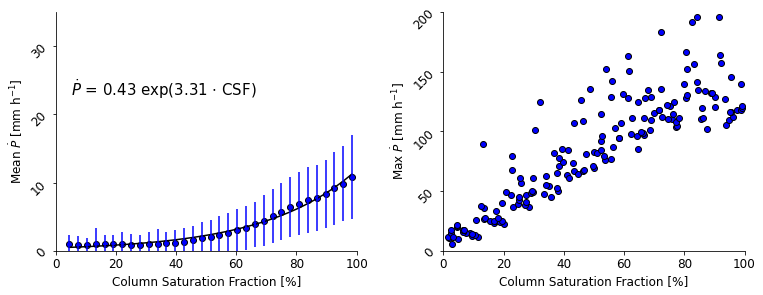

In [11]:
fig, ax = plt.subplots( 1, 2, figsize =(11, 4.5) )

ylab = [ r'Mean $\dot{P}$ [mm h$^{-1}$]', 'Max $\dot{P}$ [mm h$^{-1}$]' ]
labels = [ 'Column Saturation Fraction [%]', 'Column Saturation Fraction [%]' ]
font_size = 20
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [0, 100] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    
    if i == 0:
        y = monoexp( csf_bins/100, m, a )
        axis.plot( csf_bins, y, lw=1.5, color='k' )
        axis.scatter( csf_bins, pmax_vals2, color = 'blue', edgecolor='k' )
        axis.errorbar( csf_bins, pmax_vals2, xerr=None, yerr=pmax_error2/2, color = 'blue', ls='none' )
        axis.set_ylim([0, 35])
        axis.text( 0.05, 0.65, r'$\dot P$ = {:.2f} exp({:.2f} $\cdot$ CSF)'.format(m,a), transform=axis.transAxes, fontsize=15 )
    elif i == 1:
        axis.scatter( csf_max.flatten(), pmax_max2.flatten(), color = 'blue', edgecolor='k' )
        axis.set_ylim([0, 200])

plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/csf-precip-ERAI-percentiles-AMS-poster.pdf', bbox_inches='tight' )
plt.show()

## Binning of saturation deficit and CAPE -- mean and maximum

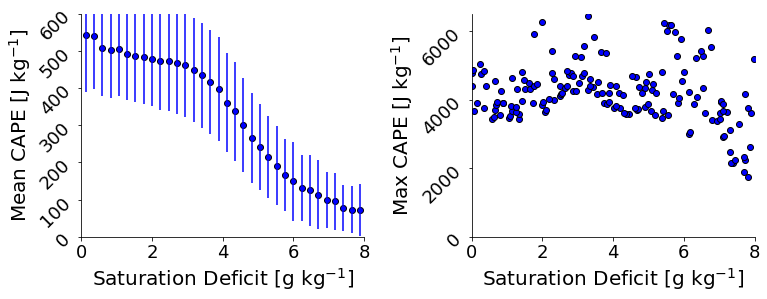

In [21]:
fig, ax = plt.subplots( 1, 2, figsize =(11, 4.5) )

ylab = [ r'Mean CAPE [J kg$^{-1}$]', r'Max CAPE [J kg$^{-1}$]' ]
labels = [ r'Saturation Deficit [g kg$^{-1}$]', r'Saturation Deficit [g kg$^{-1}$]' ]
font_size = 18
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [0, 8] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    #axis.get_xticks().set_rotation(45)
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    
    if i == 0:
        axis.scatter( sd_bins, cape_vals, color='blue', edgecolor='k' )
        axis.errorbar( sd_bins, cape_vals, xerr=None, yerr=cape_error/3.5, color = 'blue', ls='none' )
        axis.set_ylim([0, 600])
    elif i == 1:
        cape_max_flat = cape_max.flatten()
        sd_max_flat = sd_max.flatten()
        #print(len(np.where(cape_max_flat>=6500)[0])) # how many outliers?
        sd_max_flat = sd_max_flat[cape_max_flat < 6500] # removing 6 outliers
        cape_max_flat = cape_max_flat[cape_max_flat < 6500] # removing 6 outliers
        axis.scatter( sd_max_flat, cape_max_flat, color = 'blue', edgecolor='k' )
        axis.set_ylim([0, 6510])

plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/sd-cape-ERAI-percentiles-AMS-poster.pdf', bbox_inches='tight' )
plt.show()

## Binning of CAPE and ascent rate -- mean and maximum

In [13]:
# Read in the vertical velocities
omega_array = nc_open_compile(file_years,"omega",'stack')
# Extract the value around 500 hPa
omega_ERAI_mid = omega_array[:,14]

# Filter for negative values of omega (ascent rates)
omega_ERAI_mid_n, cape_array_n = negative_vals( omega_ERAI_mid, cape_array )
cape_bins_ascent, ascent_bins, ascent_95_bins, ascent_99_bins, cape_error_ascent, ascent_error, cape_max_ascent, ascent_max = \
    bin_stat_function( 50, 0, 4500, cape_array_n, omega_ERAI_mid_n, threshold=5 ) 

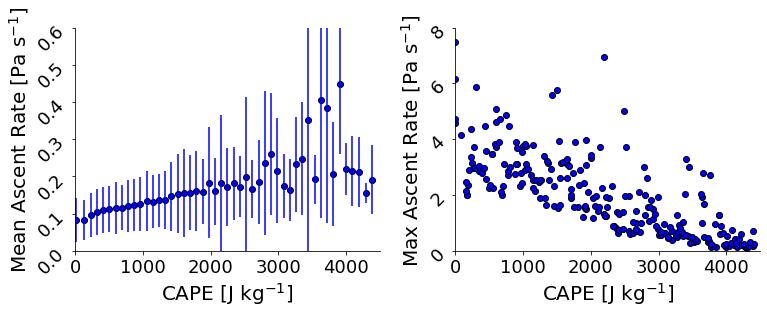

In [14]:
fig, ax = plt.subplots( 1, 2, figsize =(11, 4.5) )

ylab = [ r'Mean Ascent Rate [Pa s$^{-1}$]', r'Max Ascent Rate [Pa s$^{-1}$]' ]
labels = [ r'CAPE [J kg$^{-1}$]', 'CAPE [J kg$^{-1}$]' ]
font_size = 18
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [0, 4500] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    
    if i == 0:
        axis.scatter( cape_bins_ascent, ascent_bins, color = 'blue', edgecolor='black' )
        axis.errorbar( cape_bins_ascent, ascent_bins, xerr=cape_error_ascent/2, yerr=ascent_error/2, color = 'blue', ls='none' )
        axis.set_ylim([0, 0.6])
    elif i == 1:
        axis.scatter( cape_max_ascent.flatten(), ascent_max.flatten(), color='blue', edgecolor='black' )
        axis.set_ylim([0, 8])

plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/ascent-CAPE-ERAI-AMS-poster.pdf', bbox_inches='tight' )
plt.show() 

## Precipitation efficiency

In [17]:
# Calculate the gradient with respect to pressure of the saturation vapor mixing ratio
p_ERAI = (xr.open_dataset(file_years[0])).pressure.data*100. # converting hPa -> Pa
dqvsat_dp_ERAI = np.gradient( qvsat_ERAI, p_ERAI, axis=1 )

# Multiply the gradient with respect to pressure by pressure velocity
omega_array = nc_open_compile(file_years,"omega",'stack')
omega_ERAI = positive_to_nan(omega_array)[tropical_indx]
integrand = 100*omega_ERAI*dqvsat_dp_ERAI/g
print(np.nanmin(p_ERAI),np.nanmean(p_ERAI),np.nanmax(p_ERAI))
print(np.nanmin(integrand),np.nanmean(integrand),np.nanmax(integrand))

# Integrate the condensation rate over the pressures
cond_rate_ERAI = np.trapz(x=p_ERAI,y=-1.*integrand)
peff_ERAI = pmax_ERAI / 3600 / cond_rate_ERAI
print( np.nanmin(peff_ERAI), np.nanmedian(peff_ERAI), np.nanmax(peff_ERAI) )

12261.37 59708.367 100202.36
-2.8318388510683808e-05 -2.0164980781059883e-07 3.435145040402425e-05
-4.82065535436348 0.06900063417672554 3.770675632623986


In [16]:
# Thermodynamic parameters - how strong is correlation with these?
t2m_array = nc_open_compile(file_years,"t2m")
t2m_ERAI = negative_to_nan(t2m_array)[tropical_indx]
dpt_array = nc_open_compile(file_years,"dpt")
dpt_ERAI = negative_to_nan(dpt_array)[tropical_indx]
sst_array = nc_open_compile(file_years,"sst")
sst_ERAI = negative_to_nan(sst_array)[tropical_indx]

In [28]:
# Storm morphology parameters - how strong is correlation with these?
rad_array = nc_open_compile(file_years,"rad")
rad_ERAI = negative_to_nan(rad_array)[tropical_indx]
ctt_array = nc_open_compile(file_years,"ctt")
ctt_ERAI = negative_to_nan(ctt_array)[tropical_indx]
maxrad_array = nc_open_compile(file_years,"maxrad")
maxrad_ERAI = negative_to_nan(maxrad_array)[tropical_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERAI = negative_to_nan(minctt_array)[tropical_indx]
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERAI = negative_to_nan(lifetime_array)[tropical_indx]

# Integrated amounts of cloud condensate - how strong is correlation with these?
qi_array = nc_open_compile(file_years,"qi","stack")
qi_ERAI = negative_to_nan(qi_array)[tropical_indx]
IWP_ERAI = np.cumsum( rho_water*qi_ERAI, axis=1 )*1000 # [g m-2]
IWP_ERAI = IWP_ERAI[:,-1]
qc_array = nc_open_compile(file_years,"qc","stack")
qc_ERAI = negative_to_nan(qc_array)[tropical_indx]
LWP_ERAI = np.cumsum( rho_water*qc_ERAI, axis=1 )*1000 # [g m-2]
LWP_ERAI = LWP_ERAI[:,-1]

# CAPE and integrated mass flux - how strong is correlation with these?
cape_array = nc_open_compile(file_years,"cape")
cape_ERAI = negative_to_nan(cape_array)[tropical_indx]
capepre_array = nc_open_compile(file_years,"capepre")
capepre_ERAI = negative_to_nan(capepre_array)[tropical_indx]
capepre6_array = nc_open_compile(file_years,"capepre6")
capepre6_ERAI = negative_to_nan(capepre6_array)[tropical_indx]
omega_array = nc_open_compile(file_years,"omega","stack")
omega_ERAI = positive_to_nan(omega_array)[tropical_indx]
#omegaint_ERAI = np.cumsum( rho*w_ERAI, axis=1 )*1000 # [g m-2]
#print(omegaint_ERAI.shape)
#omegaint_ERAI = omegaint_ERAI[:,-1]
#print(omegaint_ERAI.shape)

In [29]:
# Filter for the correlations below
cape_ERAI = cape_ERAI[peff_ERAI >= 0]
capepre_ERAI = capepre_ERAI[peff_ERAI >= 0]
capepre6_ERAI = capepre6_ERAI[peff_ERAI >= 0]
rad_ERAI = rad_ERAI[peff_ERAI >= 0]
ctt_ERAI = ctt_ERAI[peff_ERAI >= 0]
maxrad_ERAI = maxrad_ERAI[peff_ERAI >= 0]
minctt_ERAI = minctt_ERAI[peff_ERAI >= 0]
IWP_ERAI_2 = IWP_ERAI[peff_ERAI >= 0]

In [30]:
omega_ERA_2 = omega_ERAI[peff_ERAI>=0,:]
#wint_ERAI = wint_ERAI[peff_ERAI >= 0]
LWP_ERAI_2 = LWP_ERAI[peff_ERAI >= 0]
lifetime_ERAI = lifetime_ERAI[peff_ERAI >= 0]
t2m_ERAI = t2m_ERAI[peff_ERAI >= 0]
dpt_ERAI = dpt_ERAI[peff_ERAI >= 0]
sst_ERAI = sst_ERAI[peff_ERAI >= 0]

pmax_ERAI_2 = pmax_ERAI[peff_ERAI >= 0]
peff_ERAI = peff_ERAI[peff_ERAI >= 0]

In [31]:
print('Correlation of precip efficiency with storm morphology parameters')
print( ma.corrcoef(rad_ERAI, peff_ERAI)[0,1] )
print( ma.corrcoef(maxrad_ERAI, peff_ERAI)[0,1] )
print( ma.corrcoef(ctt_ERAI, peff_ERAI)[0,1] )
print( ma.corrcoef(minctt_ERAI, peff_ERAI)[0,1] )
print( ma.corrcoef(lifetime_ERAI, peff_ERAI)[0,1] )
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
#print('Correlation of precip efficiency with LWP versus IWP')
#print( np.corrcoef(LWP_ERAI_2[~np.isnan(LWP_ERAI_2)], peff_ERAI[~np.isnan(LWP_ERAI_2)])[0,1] )
#print( np.corrcoef(IWP_ERAI_2[~np.isnan(IWP_ERAI_2)], peff_ERAI[~np.isnan(IWP_ERAI_2)])[0,1] )
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Correlation of precip efficiency with various surface temperatures')
print( np.corrcoef(t2m_ERAI, peff_ERAI)[0,1] )
print( np.corrcoef(sst_ERAI[~np.isnan(sst_ERAI)], peff_ERAI[~np.isnan(sst_ERAI)])[0,1] )
print( np.corrcoef(dpt_ERAI, peff_ERAI)[0,1] )
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Correlation of precip efficiency with CAPE, integrated mass flux, and w')
print( np.corrcoef(cape_ERAI[~np.isnan(cape_ERAI)], peff_ERAI[~np.isnan(cape_ERAI)])[0,1] )
print( np.corrcoef(capepre_ERAI[~np.isnan(capepre_ERAI)], peff_ERAI[~np.isnan(capepre_ERAI)])[0,1] )
print( np.corrcoef(capepre6_ERAI[~np.isnan(capepre6_ERAI)], peff_ERAI[~np.isnan(capepre6_ERAI)])[0,1] )
#print( np.corrcoef(wint_ERAI, peff_ERAI)[0,1] )
#for i in np.arange(w_ERA_2.shape[1]):
#    print( np.corrcoef(w_ERA_2[:,i], peff_ERAI)[0,1] )

Correlation of precip efficiency with storm morphology parameters
0.1968143373461888
0.06898270584128938
0.050381237784257425
-0.03981219283639907
0.04364222299217337
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Correlation of precip efficiency with various surface temperatures
-0.020787513017533208
0.01180654966924733
0.06400188672158702
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Correlation of precip efficiency with CAPE, integrated mass flux, and w
0.02420648209481083
0.01597073434982182
0.01245603866853693


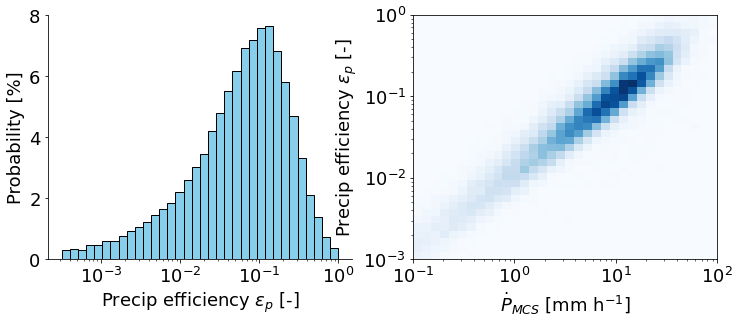

In [32]:
fs = 18
fig, ax = plt.subplots( 1, 2, figsize =(12, 4.5) )

wgts = np.ones_like( peff_ERAI )/float( len( peff_ERAI ) )*100
ax[0].hist( peff_ERAI, bins=np.logspace(-3.5, 0, 35), weights=wgts, color='skyblue', edgecolor='black' )
ax[0].set_ylabel( 'Probability [%]', fontsize=fs )
ax[0].set_xlabel( r'Precip efficiency $\varepsilon_p$ [-]', fontsize=fs )
ax[0].set_xscale( 'log' )
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[1].hist2d( pmax_ERAI_2, peff_ERAI, bins=[ np.logspace(-1,2,35), np.logspace(-3,0,35) ], cmap=plt.cm.Blues )
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'Precip efficiency $\varepsilon_p$ [-]', fontsize=fs)
ax[1].set_xlabel(r'$\dot{P}_{MCS}$ [mm h$^{-1}$]', fontsize=fs)

fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/precipeff-ERAI-AMS-poster.pdf', bbox_inches='tight' )
plt.show()